In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import seaborn as sns

#for plot with ATLAS styple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #If the line below doesn't work, uncomment this line (make sure to comment the line below); it should help.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Layer
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import uproot
import gc

from cells import Cells 
from nn import NN

MCdata="cell_analysis_mu60"
MC_root = f"../re21.9/{MCdata}/cells.root"
tree_name = "ntuple"
        
cell_data = Cells(MC_root, unit="GeV")
#cell_imgs, cell_label = cell_data.cimg(0.2)
cell_vecs, cell_vlabel = cell_data.cvector(0.02)
#cell_vecs, cell_vlabel = cell_vecs*0.1, cell_vlabel*0.1
#cell_vecs, cell_vlabel = cell_imgs.reshape((100, -1))*0.1, cell_vlabel*0.1



2022-09-13 20:55:46.072374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [11]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
class Sum(Layer):
    """
    Simple sum layer à la Dan Guest
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=2)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

    def compute_mask(self, inputs, mask):
        return None
    
class MET(Layer):
    """
    Simple sum layer à la Dan Guest
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
            x=K.square(x)
            x=K.sum(x, axis=-1)
        return K.sqrt(x)

    def compute_output_shape(self, input_shape):
        return (input_shape[0])

    def compute_mask(self, inputs, mask):
        return None
#model_nn = NN([100,100], learning_rate=1e-3)

class MeanSquaredError(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_sum(tf.math.square(y_pred + y_true), axis=-1)

model_nn = Sequential([
    #Sum(name='sum'),
    Flatten(),
    #Dense(64, activation='relu'),
    Dense(128, activation='linear'),
    #Dense(128,activation='relu'),
    #Dense(2,activation='relu'),
    #MET(name="MET"),
    Dense(2)
  ])

model_nn.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(1e-3))

In [12]:
cell_vecs[ (cell_vecs<1.)&(cell_vecs>-1)]=0
x_train, y_train = cell_vecs[:-500,:], cell_vlabel[:-500]
x_test, y_test = cell_vecs[-500:,:], cell_vlabel[-500:]
#x_train.sort()
#x_test.sort()
#y_train = np.sqrt( np.sum(y_train**2, axis=-1) )
#y_test = np.sqrt( np.sum(y_test**2, axis=-1) )

#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(x_train)

#normalizer_label = tf.keras.layers.Normalization(axis=None)
#normalizer_label.adapt(y_train)

history = model_nn.fit(x_train, y_train, epochs=100, verbose=0,
                       validation_split = 0.3)


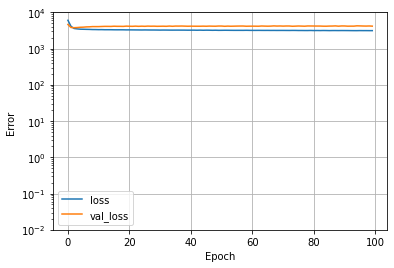

In [13]:
def plot_loss(history):
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.ylim([0.01, 10000])
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Error ')
        plt.legend()
        plt.grid(True)
plot_loss(history)

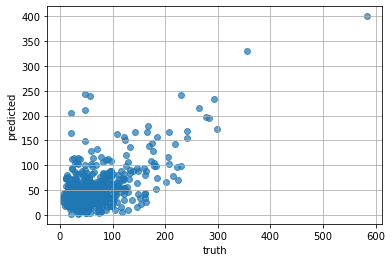

In [14]:
predicted = model_nn.predict(x_test)

plt.scatter( np.sqrt(np.sum(y_test**2,axis=-1) ),np.sqrt(np.sum(predicted**2,axis=-1) ), marker='o', alpha=0.7)
plt.xlabel("truth")
plt.ylabel("predicted")
plt.grid()

In [87]:
history.history['loss']

[43.03554153442383,
 42.45100784301758,
 42.16459274291992,
 42.077701568603516,
 42.02887725830078,
 42.01643753051758,
 41.953636169433594,
 41.98527908325195,
 41.95751953125,
 41.89759826660156,
 41.91303253173828,
 41.89177703857422,
 41.894805908203125,
 41.98796463012695,
 41.8895378112793,
 41.90283203125,
 41.93588638305664,
 41.932682037353516,
 41.93370056152344,
 41.924827575683594,
 41.918949127197266,
 42.072208404541016,
 41.94525146484375,
 41.82855224609375,
 41.98384094238281,
 41.840301513671875,
 41.83515930175781,
 41.851722717285156,
 41.867759704589844,
 41.893253326416016,
 41.82624053955078,
 41.8567008972168,
 41.911041259765625,
 41.93135452270508,
 41.849613189697266,
 41.88644790649414,
 41.84880828857422,
 41.86715316772461,
 41.861839294433594,
 41.83830261230469,
 41.796875,
 41.85980224609375,
 41.77027130126953,
 41.901885986328125,
 41.968074798583984,
 41.85279846191406,
 41.82924270629883,
 41.860877990722656,
 41.773834228515625,
 41.86734008789062